# Shepherd et al., Image Segmentation

RSGISLib is a set of Python modules which have been developed over the years to support our data processing needs.

The modules provide a set of high level functions, at a similar level to ArcGIS / QGIS toolbox functions or tools in ENVI or Erdas Imagine. The idea is that you can join a number of functions together to undertake your analysis or put those functions within a loop and process a number of input images.

In this tutorial we will look at using the Shepherd et al., image segmentation to create image objects from an input image, which can then be used for further image analysis (e.g., classification). 


## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_


## 1. Import Modules

In [5]:
# Import shepherd segmentation module
import rsgislib
from rsgislib.segmentation import shepherdseg

# other moduls for viz
import matplotlib
import matplotlib.pyplot as plt
from rsgislib.tools import plotting

## 2. Visualise Input Image

Image Data Size: 931 x 947


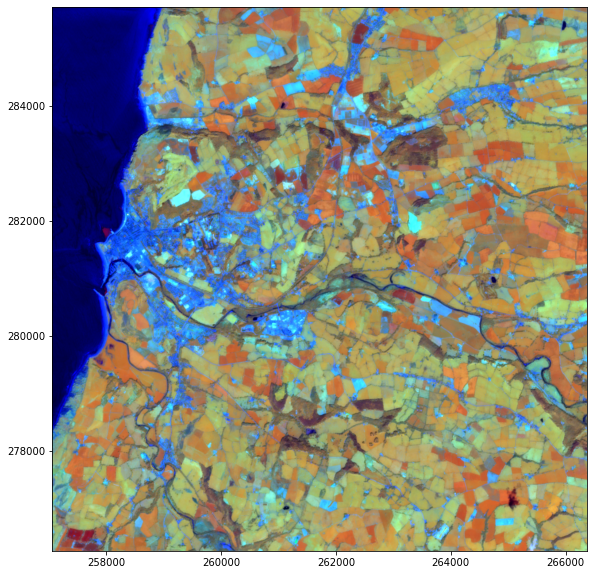

In [6]:
input_img = '../data/sen2_20210527_aber.tif'

### Input image
# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we 
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is 
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(input_img, bands=[8,9,3])

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

## 3. Run Shepherd et al., Segmentation

Please note the output format needs to be an image file format which support Raster Attribute Tables (RATs), which basically means using either KEA or HFA (i.e., the Erdas Imagine \*.img format). For the majority of use cases you will most likely want to use the KEA file format.


In [7]:
out_clumps_img = './sen2_20210527_aber_segs.kea'
out_mean_img = './sen2_20210527_aber_meanimg.kea'
tmp_dir = './tmp/'

shepherdseg.run_shepherd_segmentation(
    input_img,
    out_clumps_img,
    out_mean_img,
    tmp_dir,
    gdalformat="KEA", # Output file format
    calc_stats=True, # Calculate statistics on the output images
    no_stretch=False, # Normalise the input bands by applying a 2 standard devation stretch
    no_delete=False, # Delete the temporary files created during the processing
    num_clusters=60, # The number of clusters (k) for the initial kMeans clustering
    min_n_pxls=100, # Minimum number of pixels within a clump (segment)
    dist_thres=100,
    bands=[8,9,3], # Just use bands 8 (NIR), 9 (SWIR) and 3 (Red)
    sampling=100, # Speed up the kMeans clustering by only using every 100th pixel.
    km_max_iter=200, # Maximum number of kMeans iterations
    process_in_mem=True, # Do the process using in-memory datasets rather than to disk
    save_process_stats=False,
    img_stretch_stats="",
    kmeans_centres="",
    img_stats_json_file="",
)

Subsetting the image bands
New image width = 931 height = 947 bands = 3
Stretch Input Image



Band[1] Min = 13 Mean = 448.339837374 (Std Dev = 170.100843825) max = 844
Band[2] Min = 5 Mean = 199.761055603 (Std Dev = 66.6435556283) max = 747
Band[3] Min = 11 Mean = 47.7343090729 (Std Dev = 26.2617507701) max = 1111
New image width = 931 height = 947 bands = 3

Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.New image width = 931 height = 947 bands = 3


Image: ./tmp/sen2_20210527_aber_bselect.kea
	 Variable 'b1' is band 1
New image width = 931 height = 947 bands = 1

Mask stretched Image.
New image width = 931 height = 947 bands = 3

Deleting file: ./tmp/sen2_20210527_aber_stchdonly.kea
Deleting file: ./tmp/sen2_20210527_aber_stchdonly_off.kea
Deleting file: ./tmp/sen2_20210527_aber_stchdmaskonly.kea
Performing KMeans.
inputImage = ./tmp/sen2_20210527_aber_stchd.kea
outputMatrixFile = ./tmp/sen2_20210527_aber_kmeansclust

## 4. Visualise the Segmentation

Image Data Size: 931 x 947


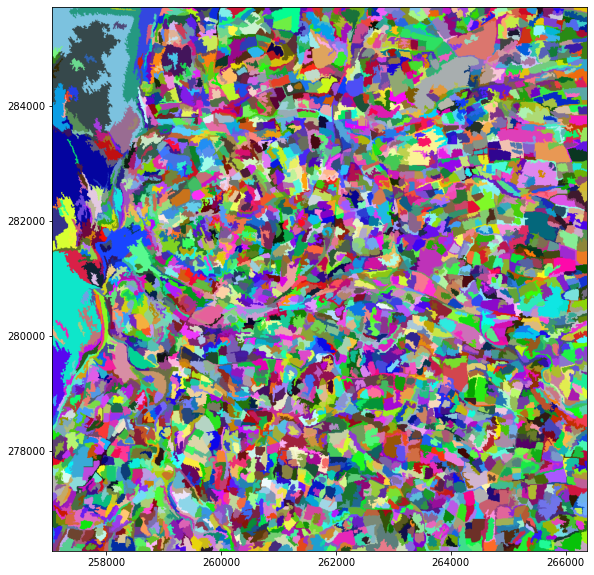

In [8]:
# Get the image data as a numpy array and the spatial bounding
# box of the image data. The returned array will be a colour (R,G.B)
# image with the colours from the colour table.
img_data, img_coords, ldg_patches = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(out_clumps_img)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data, extent=img_coords)